# ML-Leaks Adversary 3

## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


import models

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 10
batch_size = 256
lr = 0.001

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def eval_target_net(net): 
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(cifar10_testloader):
            
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            output = net(imgs)
            
            predicted = output.argmax(dim=1)
            
            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()
            
            
            for prediction, lbl in zip(predicted, lbls): 
            
                class_correct[lbl] += prediction == lbl
                class_total[lbl] += 1 
            
    for i in range(10):
        print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nTotal accuracy = %.2f %%\n\n" % (100*(correct/total)) )
    
    
def eval_membership_inference(target_net, target_train, target_out): 

    target_net.eval()
    
    precisions = []
    recalls = []
    accuracies = []
    
    #for threshold in np.arange(0.5, 1, 0.005): 
    thresholds = np.arange(0.5, 1, 0.005)

    total = np.zeros(len(thresholds))
    correct = np.zeros(len(thresholds))

    true_positives = np.zeros(len(thresholds))
    false_positives = np.zeros(len(thresholds))
    false_negatives = np.zeros(len(thresholds))

    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)): 


        mini_batch_size = train_imgs.shape[0]
        train_imgs, out_imgs = train_imgs.to(device), out_imgs.to(device)

        train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
        out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)

        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top = train_sort[:,0].clone().to(device)

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top = out_sort[:,0].clone().to(device)

        #print(train_top.shape)

        for j, t in enumerate(thresholds):
            true_positives[j] += (train_top >= t).sum().item()
            false_positives[j] += (out_top >= t).sum().item()
            false_negatives[j] += (train_top < t).sum().item()
            #print(train_top >= threshold)


            #print((train_top >= threshold).sum().item(),',',(out_top >= threshold).sum().item())

            correct[j] += (train_top >= t).sum().item()
            correct[j] += (out_top < t).sum().item()
            total[j] += train_top.size(0) + out_top.size(0)

    #print(true_positives,',',false_positives,',',false_negatives)

    for j, t in enumerate(thresholds): 
        accuracy = 100 * correct[j] / total[j]
        precision = true_positives[j] / (true_positives[j] + false_positives[j]) if true_positives[j] + false_positives[j] != 0 else 0
        recall = true_positives[j] / (true_positives[j] + false_negatives[j]) if true_positives[j] + false_negatives[j] !=0 else 0
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

        print("threshold = %.4f, accuracy = %.2f, precision = %.2f, recall = %.2f" % (t, accuracy, precision, recall))


    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
    


## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


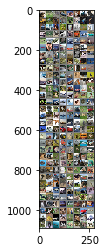

In [4]:
# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    # have to pad a few pixels for resnet
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('datasets/', train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('datasets/', train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=100, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

## ML Leaks Adversary 3 (Membership Inference Attack) 
### https://arxiv.org/abs/1806.01246

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

total_size = len(cifar10_trainset)


indices = list(range(total_size))

split = total_size // 2
target_train_idx = indices[:split]
target_out_idx = indices[split:]



target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# the model being attacked (architecture can be different than shadow)
target_net = models.mlleaks_cnn().to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)



def train(net, data_loader, optimizer, criterion, n_epochs): 
    losses = []
    for epoch in range(n_epochs): 
        net.train()
        for i, batch in enumerate(data_loader): 

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(imgs)


            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

            #print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch 
        print("[%d/%d]" %(epoch, n_epochs))
        eval_target_net(net)

        #plt.plot(losses)
        #plt.show()


In [6]:
train(target_net, target_train_loader, target_optim, target_loss, n_epochs)


[0/10]
Accuracy of airplane : 65.10 %
Accuracy of automobile : 35.40 %
Accuracy of bird : 9.20 %
Accuracy of cat : 2.30 %
Accuracy of deer : 28.50 %
Accuracy of dog : 63.00 %
Accuracy of frog : 66.70 %
Accuracy of horse : 47.90 %
Accuracy of ship : 45.30 %
Accuracy of truck : 31.10 %

Total accuracy = 39.45 %


[1/10]
Accuracy of airplane : 41.00 %
Accuracy of automobile : 64.60 %
Accuracy of bird : 22.80 %
Accuracy of cat : 56.60 %
Accuracy of deer : 56.50 %
Accuracy of dog : 16.80 %
Accuracy of frog : 28.00 %
Accuracy of horse : 64.60 %
Accuracy of ship : 58.50 %
Accuracy of truck : 60.00 %

Total accuracy = 46.94 %


[2/10]
Accuracy of airplane : 41.40 %
Accuracy of automobile : 38.50 %
Accuracy of bird : 42.80 %
Accuracy of cat : 25.00 %
Accuracy of deer : 38.80 %
Accuracy of dog : 31.90 %
Accuracy of frog : 85.60 %
Accuracy of horse : 65.10 %
Accuracy of ship : 72.80 %
Accuracy of truck : 51.70 %

Total accuracy = 49.36 %


[3/10]
Accuracy of airplane : 49.10 %
Accuracy of automob

threshold = 0.5000, accuracy = 50.65, precision = 0.50, recall = 0.87
threshold = 0.5050, accuracy = 50.70, precision = 0.50, recall = 0.86
threshold = 0.5100, accuracy = 50.76, precision = 0.50, recall = 0.86
threshold = 0.5150, accuracy = 50.78, precision = 0.50, recall = 0.85
threshold = 0.5200, accuracy = 50.82, precision = 0.50, recall = 0.84
threshold = 0.5250, accuracy = 50.85, precision = 0.51, recall = 0.84
threshold = 0.5300, accuracy = 50.85, precision = 0.51, recall = 0.83
threshold = 0.5350, accuracy = 50.83, precision = 0.51, recall = 0.83
threshold = 0.5400, accuracy = 50.85, precision = 0.51, recall = 0.82
threshold = 0.5450, accuracy = 50.86, precision = 0.51, recall = 0.82
threshold = 0.5500, accuracy = 50.87, precision = 0.51, recall = 0.81
threshold = 0.5550, accuracy = 50.86, precision = 0.51, recall = 0.80
threshold = 0.5600, accuracy = 50.88, precision = 0.51, recall = 0.80
threshold = 0.5650, accuracy = 50.93, precision = 0.51, recall = 0.79
threshold = 0.5700, 

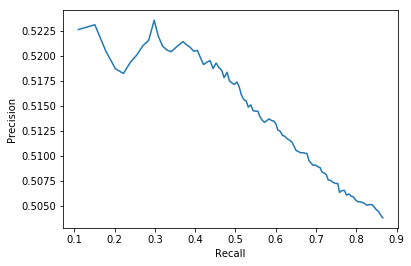

In [7]:
eval_membership_inference(target_net, target_train_loader, target_out_loader)